In [5]:
import os

from jax.tree_util import tree_map

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import torch
from torch.utils import data
from torch.utils.data import Dataset, DataLoader

import torchio as tio

In [6]:
def numpy_collate(batch):
    return tree_map(np.asarray, data.default_collate(batch))


def get_transform(cfg):
    transform = tio.Compose(
        [
            tio.RescaleIntensity(
                (0, 1), percentiles=(cfg.get("perc_low", 1), cfg.get("perc_high", 99))
            ),
        ]
    )
    return transform

In [7]:
def load_nifti(cfg, type="Training"):
    path_dataset = cfg["path_dataset"]

    csv = pd.read_csv(os.path.join(path_dataset, "data.csv"), sep=";")

    subjects = []
    for _, sub in csv.iterrows():
        if sub.Type == type:
            path_img = os.path.join(
                path_dataset, sub.Path, str(sub.ID), f"pre/mni_{cfg['modality']}.nii.gz"
            )
            path_mask = os.path.join(
                path_dataset, sub.Path, str(sub.ID), f"mni_wmh.nii.gz"
            )

            subject_dict = {
                "vol": tio.ScalarImage(path_img),
                "mask": tio.LabelMap(path_mask) if type == "Training" else None,
                "center": sub.Center,
                "ID": sub.ID,
                "path": sub.Path,
            }

            subject = tio.Subject(subject_dict)
            subjects.append(subject)
            break

    return tio.SubjectsDataset(subjects, transform=get_transform(cfg))


class vol2slice(Dataset):
    def __init__(self, cfg, ds, type):
        self.ds = ds
        self.cfg = cfg
        self.type = type

    def __len__(self):
        return len(self.ds) * self.cfg["slice_size_template"]

    def __getitem__(self, idx):
        idx_subject = idx // self.cfg["slice_size_template"]
        idx_slice = idx % self.cfg["slice_size_template"]

        subject = self.ds.__getitem__(idx_subject)

        subject["vol"][tio.DATA] = subject["vol"][tio.DATA][0, ..., idx_slice]

        if self.type == "Training":
            subject["mask"][tio.DATA] = subject["mask"][tio.DATA][0, ..., idx_slice]

            return subject["vol"][tio.DATA], subject["mask"][tio.DATA].type(
                torch.float32
            )

        return subject["vol"][tio.DATA]


def create_dataset(cfg, type="Training"):
    ds = load_nifti(cfg, type)
    ds = vol2slice(cfg, ds, type)
    return ds


class WMH:
    def __init__(self, cfg):
        self.cfg = cfg

    def setup(self):
        self.train_dataset = create_dataset(self.cfg, type="Training")
        self.test_dataset = create_dataset(self.cfg, type="Test")

    def get_train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.cfg["batch_size"],
            shuffle=True,
            num_workers=self.cfg["num_workers"],
            pin_memory=True,
            drop_last=True,
            collate_fn=numpy_collate,
        )

    def get_test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.cfg["batch_size"],
            shuffle=False,
            num_workers=self.cfg["num_workers"],
            pin_memory=True,
            collate_fn=numpy_collate,
        )

In [15]:
config = {
    "modality": "FLAIR",
    "slice_size_template": 91,
    "flair_template_path": "/Users/geoffroyoudoumanessah/Documents/these/projects/datasets/WMH/MNI-FLAIR-2.0mm.nii.gz",
    "path_dataset": "/Users/geoffroyoudoumanessah/Documents/these/projects/datasets/WMH",
    "batch_size": 32,
    "num_workers": 0,
}

wmh = WMH(config)
wmh.setup()

train_loader = wmh.get_train_dataloader()

In [16]:
i = 0
for x in train_loader:
    i += 1
    if i == 2:
        break

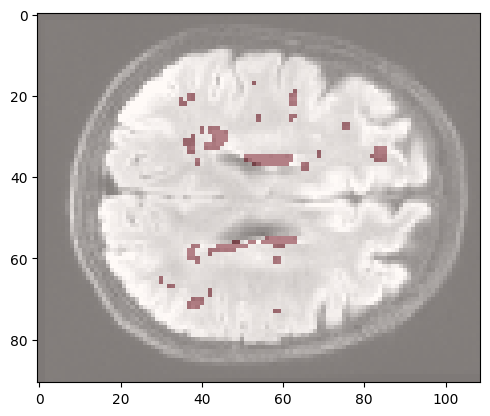

In [20]:
plt.imshow(x[0][0], cmap="gray")
plt.imshow(x[1][0].astype(np.uint8), cmap="Reds", alpha=0.5)
plt.show()